## Answering Business Questions with SQL
A dataquest guided project

Using the Chinook Database, answer business questions to practice querying the DB with more complex queries. 

Table Schema here: 
(https://s3.amazonaws.com/dq-content/190/chinook-schema.svg)

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

We can get a look at the database tables here. We can also use this query to make sure the DB is initialized properly

In [2]:
%%sql
SELECT name, type
  FROM sqlite_master
 WHERE type IN ('table', 'view')

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table



## Which Genres Sell the MOST in the USA?

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


<table>
    <td>Artist Name</td>
    <td>Genre</td>
    <tr>
    <td>Regal</td>
    <td>Hip Hop </td>
    </tr>
    <tr>
    <td>Red Tone</td>
    <td>Punk</td>
    </tr>
    <tr>
    <td>Meteor and the Girls</td>
    <td>Pop </td>
    </tr>
    <tr>
    <td>Slim Jim Bites</td>
    <td>Blues</td>
    </tr>
</table>

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.


_Planning my query: 
Return Grouped by Genre: number of tracks sold in the USA_

In [3]:
%%sql
WITH invoices_genres AS (
    SELECT 
        invoice.total AS invoicetotal,
        genre.name AS genre
    FROM invoice
    LEFT JOIN invoice_line ON invoice_line.invoice_id = invoice.invoice_id
    LEFT JOIN track ON track.track_id = invoice_line.track_id
    LEFT JOIN genre ON genre.genre_id = track.genre_id
    WHERE invoice.billing_country = "USA"
)
SELECT 
    genre,
    COUNT(invoicetotal) AS totalSales,
    ROUND(CAST(COUNT(invoicetotal) AS FLOAT) * 100/ (SELECT COUNT(*) FROM invoices_genres), 2) || "%" AS percentageOfSales,
    "$" || ROUND(SUM(invoicetotal),2) AS totalRevenue
FROM invoices_genres
WHERE genre IN ("Hip Hop/Rap", "Alternative & Punk", "Pop", "Blues")
GROUP BY genre
ORDER BY totalSales DESC;


 * sqlite:///chinook.db
Done.


genre,totalSales,percentageOfSales,totalRevenue
Alternative & Punk,130,12.37%,$1234.53
Blues,36,3.43%,$453.42
Pop,22,2.09%,$201.96
Hip Hop/Rap,20,1.9%,$366.3


We see that Alternative/Punk is a significantly better seller in the US than the other categories. Based on these resuts I might suggest that we aggressively pursue _Red Tone_ marketing. 

The other genres make up smaller portions of the revenue stream. Based on the sales percentage v total revenue it appears that Hip Hop makes up smaller sales percentages, but takes in more marketing than Pop music. 

I might suggest pursuing Punk, Blues, and Hip Hop, though the sample size of 20-36 invoices only represents a small enough sample that larger data might be helpful. 

<br>
<br>
<hr>

## Evaluating Salesperson Performances

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

_Planning My Query: I want to evaluate employees, I need to join with the customer table. From there I can investigate differences in the counts of customers, total revenues (joined with invoices), and compare against the length of time an employee has been working for us_

In [4]:
#I want my end result table to look like: 
# Employee | NumCustomers | TotalRevenue | 
#__________|______________|______________|

In [5]:
%%sql
--#Create a view that I will import to a df later
--#Drop it (if youre running it anew)
DROP VIEW IF EXISTS employeeEvaluations;
CREATE VIEW employeeEvaluations AS

--#Get a list of employees & their customers
WITH employee_customers AS (
    SELECT 
        employee.employee_id AS employee,
        customer.customer_id AS customer
    FROM employee
    LEFT JOIN customer ON customer.support_rep_id = employee.employee_id
),
--#Get customers & revenues
customer_revenues AS (
    SELECT 
        customer.customer_id AS customer,
        ROUND(SUM(invoice.total),2) AS customerRevenue
    FROM customer
    LEFT JOIN invoice ON invoice.customer_id = customer.customer_id
    GROUP BY customer
),
--#Put the employees with the customer revenues
employee_customer_revenues AS (
    SELECT 
        employee_customers.employee AS employee,
        COUNT(employee_customers.customer) AS numCustomers,
        SUM(customer_revenues.customerRevenue) AS totalRevenue
    FROM employee_customers
    LEFT JOIN customer_revenues ON customer_revenues.customer = employee_customers.customer
    GROUP BY employee_customers.employee
    ORDER BY totalRevenue DESC
)
SELECT employee, numCustomers, totalRevenue FROM employee_customer_revenues;

 * sqlite:///chinook.db
Done.
Done.


[]

In [6]:
%%sql
SELECT * FROM employeeEvaluations;

 * sqlite:///chinook.db
Done.


employee,numCustomers,totalRevenue
3,21,1731.51
4,20,1584.0000000000002
5,18,1393.92
1,0,None
2,0,None
6,0,None
7,0,None
8,0,None


In [7]:
#Let's make a dataframe from these results
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect('chinook.db')
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_sql_query("""SELECT  *
                          FROM employeeEvaluations""", conn)
df

,employee,numCustomers,totalRevenue
0,3,21,1731.51
1,4,20,1584.00
2,5,18,1393.92
3,1,0,NaN
4,2,0,NaN
5,6,0,NaN
6,7,0,NaN
7,8,0,NaN


Text(0.5, 1.0, 'Number of Customers by Employee')

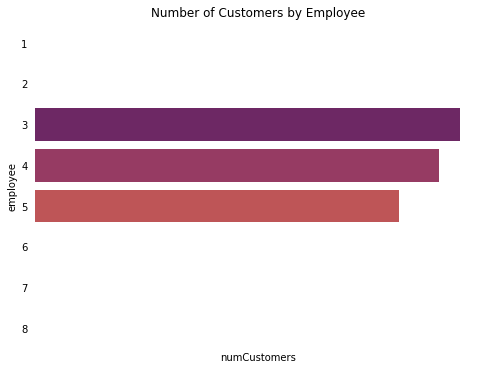

In [8]:
# Plot It
plt.figure(figsize=(8,6))

# Highlights survey_fields that have a correlation above 0.2
ax = sns.barplot(x = df['numCustomers'], 
                 y = df['employee'],
                 data = df,
                 palette = 'inferno', 
                 orient = 'h')
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
ax.set_xticks([])
ax.set_title("Number of Customers by Employee")

Text(0.5, 1.0, 'Value of Revenue by Employee')

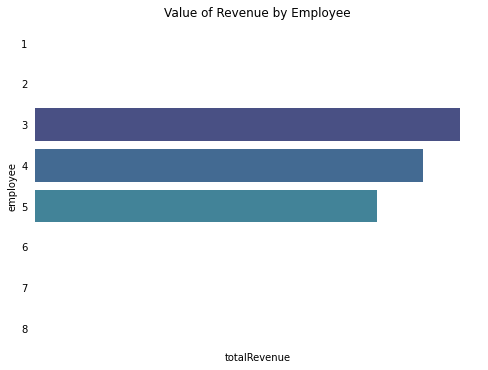

In [9]:
plt.figure(figsize=(8,6))

# Highlights survey_fields that have a correlation above 0.2
ax = sns.barplot(x = df['totalRevenue'], 
                 y = df['employee'],
                 data = df,
                 palette = 'mako', 
                 orient = 'h')
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
ax.set_xticks([])
ax.set_title("Value of Revenue by Employee")

We can see that there is negligible difference between our top three sales reps. There are 5 employees who have not yet recorded a sale
<br>
<br>

## Evaluating customers by country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. 


_Query Plan: 
Write a query that collates data on purchases from different countries.
Where a country has only one customer, collect them into an "Other" group.
The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom._

In [81]:
%%sql
--#Create a view that I will import to a df later
--#Drop it (if youre running it anew)
DROP VIEW IF EXISTS customerEvaluations;
CREATE VIEW customerEvaluations AS

WITH
    --#create a table of country/count of customers
    country_count_table AS (
        SELECT 
            country AS country,
            count(customer.customer_id) AS custCount
        FROM 
            customer
        GROUP BY country
        ORDER BY count(*) DESC
    ),
    
    --#A table that gives me the value of sales for each country
    country_sales_table AS (
        SELECT 
            customer.country AS country,
            COUNT(invoice.invoice_id) AS totalInvoices,
            SUM(invoice.total) AS sumInvoices
        FROM 
            customer
        INNER JOIN invoice ON invoice.customer_id = customer.customer_id
        GROUP BY customer.country
    ),
    
    --#A table that joins the counts of customers and invoices for a given country
    country_sales_summary AS (
        SELECT 
            country_sales_table.country AS country,
            country_count_table.custCount AS totalCustomers,
            country_sales_table.totalInvoices AS totalSales,
            ROUND(country_sales_table.sumInvoices,2) AS totalRevenue
        FROM 
            country_sales_table
        INNER JOIN country_count_table ON country_count_table.country = country_sales_table.country
        GROUP BY country_sales_table.country  
        ORDER BY totalRevenue DESC
    ),
    
    --#A table that summarizes the countries and calculates the average sales
    country_sales_evaluation AS (
        SELECT 
            country_sales_summary.country AS country,
            country_sales_summary.totalCustomers AS totalCustomers,
            country_sales_summary.totalSales AS totalSales,
            ROUND(country_sales_summary.totalSales / country_sales_summary.totalCustomers, 0) AS salesPerCust,
            country_sales_summary.totalRevenue AS totalRevenue,
            ROUND(country_sales_summary.totalRevenue / country_sales_summary.totalCustomers, 2) AS revenuePerCust,
            ROUND(country_sales_summary.totalRevenue / country_sales_summary.totalSales, 2) AS revenuePerSale
        FROM 
            country_sales_summary
    )

SELECT * FROM country_sales_evaluation;

 * sqlite:///chinook.db
Done.
Done.


[]

In [82]:
%%sql
Select * FROM customerEvaluations;

 * sqlite:///chinook.db
Done.


country,totalCustomers,totalSales,salesPerCust,totalRevenue,revenuePerCust,revenuePerSale
USA,13,131,10.0,1040.49,80.04,7.94
Canada,8,76,9.0,535.59,66.95,7.05
Brazil,5,61,12.0,427.68,85.54,7.01
France,5,50,10.0,389.07,77.81,7.78
Germany,4,41,10.0,334.62,83.66,8.16
Czech Republic,2,30,15.0,273.24,136.62,9.11
United Kingdom,3,28,9.0,245.52,81.84,8.77
Portugal,2,29,14.0,185.13,92.57,6.38
India,2,21,10.0,183.15,91.58,8.72
Ireland,1,13,13.0,114.84,114.84,8.83


We can see that the US provides the biggest revenue, with also the most customers and total sales. 

<br>
<br>

## 